In [68]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from time import sleep
from time import time

In [47]:
url = 'https://fr.trustpilot.com/review/www.cdiscount.com'
html = requests.get(url)
html

<Response [200]>

In [48]:
# URL triée par date du commentaire (page 1 les plus récents)
url_tri = 'https://fr.trustpilot.com/review/cdiscount.com?languages=all&page=1&sort=recency'

In [49]:
# URL pour requêter les 30 derniers jours
url_30days = 'https://fr.trustpilot.com/review/www.cdiscount.com?date=last30days'

In [50]:
# transformation de la page en un document exploitable
# Selon le parsers choisi (html.parser, lxml, lxml-xml, xml, html5lib)
soup = BeautifulSoup(html.text, 'html.parser')

### Date du commentaire

In [51]:
# la date à récupérer
date_time = soup.find_all('time', {'class' : ""})
date_time[2]['datetime'][0:19].replace('T', ' ')

'2023-11-25 11:47:17'

### Récupération du pays du commentaire

In [52]:
pays = soup.find_all('div', {"class" : "typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua"})

### note et commentaire

In [53]:
# Chercher à partir de la valeur d'une balise tous les éléments d'un commentaire
comment = soup.find_all('p' , {'class' : "typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"})
comment[0].text

"J'ai eu une très bonne expérience même si ma commande a été retourner parce qu'il y avait un problème , je reste positif car le service client est génial et correct je donne 5 étoiles 🌟🌟🌟🌟🌟  en plus"

In [54]:
note = soup.find_all('div', {"class" : "styles_reviewHeader__iU9Px"})
print(note[2]['data-service-review-rating'])

5


In [69]:
t0 = time()

# recherche sur plusieurs pages
nb_pages = 10
liste_url = []
page = 1

while page <= nb_pages :
    liste_url.append('https://fr.trustpilot.com/review/www.cdiscount.com?page='+str(page)+'&sort=recency')
    page = page + 1

liste_note = []
liste_commentaire = []
liste_date = []
liste_pays = []

for url in tqdm(liste_url):
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    comment = soup.find_all('p' , {'class' : "typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"})
    note = soup.find_all('div', {"class" : "styles_reviewHeader__iU9Px"})
    pays = soup.find_all('div', {"class" : "typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua"})
    date_time = soup.find_all('time', {'class' : ""})
    
    for nb_avis in range(len(comment)):
        liste_note.append(note[nb_avis]['data-service-review-rating'])
        liste_date.append(date_time[nb_avis]['datetime'][0:19].replace('T', ' '))
        liste_pays.append(pays[nb_avis].span.text)
        
        try :
            liste_commentaire.append(comment[nb_avis].text)
        
        except:
            liste_commentaire.append('NaN')

    sleep(5)

# affichage du temps de calcul par rapport  à l'initialisation en début de requête 
print('le temps de calcul est de {:.2f} secondes'.format(time()-t0))

 64%|███████████████████████████████████████████████▎                          | 5910/9240 [8:54:23<5:01:06,  5.43s/it]


ConnectionError: HTTPSConnectionPool(host='fr.trustpilot.com', port=443): Max retries exceeded with url: /review/www.ubaldi.com?page=5911&sort=recency (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028F7BBDC790>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [71]:
# constitution d'un dictionnaire regroupant les données
dico = {'note' : liste_note, 'commentaire' : liste_commentaire, 'pays' : liste_pays, 'date' : liste_date}

# constitution d'un DataFrame à partir du dictionnaire 
df = pd.DataFrame(dico)

In [70]:
print(len(liste_commentaire))
print(len(liste_note))
print(len(liste_pays))
print(len(liste_date))

97783
97783
97783
97783


In [72]:
df.tail(10)

,note,commentaire,pays,date
97773,5,"Très bon suivi, rien à dire",FR,2020-02-12 10:33:07
97774,2,Livraison OK en 48 H00Produit conformeconditio...,FR,2020-02-12 10:25:26
97775,5,Super site. Livraison dans les temps,FR,2020-02-12 10:21:21
97776,5,"Transport impeccable,livreurs épatants et expé...",FR,2020-02-12 10:20:33
97777,5,PARFAIT PRODUIT DISPONIBLE AVEC LIVRAISON RAPIDE,FR,2020-02-12 10:18:08
97778,5,colis en bonne état avec un peu de retard(un j...,FR,2020-02-12 10:12:27
97779,5,"Facile, clair, rapide, livraison dans la pièce...",FR,2020-02-12 10:04:32
97780,5,Super transaction : prix intéressant et livrai...,FR,2020-02-12 10:01:26
97781,4,Rien à signaler Délai respecté Livraisons parf...,FR,2020-02-12 09:49:37
97782,5,colis en bon etat delai de livraison respecter,FR,2020-02-12 09:44:57


C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='note', ylabel='count'>

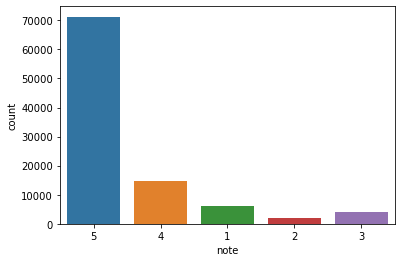

In [73]:
import seaborn as sns
sns.countplot(df['note'])

In [74]:
df.to_csv('datasets/SatisfactionClients/cdiscount.csv', sep=';')